## Using a Pretrained Network: Feature Extraction

Convnets used for image classification comprise of two parts: a series of convolutional and pooling layers followed by a densely connected classifier layer. The first part is called the _convolutional base_ of the network. In the context of convolutional networks, _feature extraction_ using a pre-trained network consists of using the convolutional base of this pre-trained network and passing new data through it and then feeding its output to a new, as yet untrained, convnet. 

In our case, we will pass the images of cats and dogs through the convolutional base of the VGG16 Network and then use its output as input for our own network that is specifically being trained to distinguish dogs from cats. One can think of this process as training the new convnet to learn the image representations of the pre-trained network. The classifier of the pre-trained network is specific to the classification problem at hand. Furthermore, the dense classifier totally ignores the spatial position of features such as edges, colours and textures. In the case of VGG16, its classifier is trained on 1000 different classes. The weights information of the classifier itself is not very useful while training a new model to distinguish dogs from cats. 

## Instantiating the VGG16 Convolutional Base

In [1]:
from keras.applications import VGG16

# The include_top argument specifies whether we want to include the densely connected classifier in the top
conv_base = VGG16(weights='imagenet', 
                  include_top=False, 
                  input_shape=(150, 150, 3))

In [2]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

## Imports, Directory Paths

In [3]:
import os
import numpy as np

from keras.preprocessing.image import ImageDataGenerator
from keras import models
from keras import layers
from keras import optimizers


base_dir = './'

train_dir = os.path.join(base_dir, 'train') 
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')                           

validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')                 
                                             
test_cats_dir = os.path.join(test_dir, 'cats')
test_dogs_dir = os.path.join(test_dir, 'dogs') 

## Extracting Features from a Pre-trained Convnet

In [4]:
def extract_features(directory, datagen, sample_count, batch_size=20):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')
    
    i = 0
    
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        
        i += 1
        
        if i * batch_size >= sample_count:
            break                                                         
    
    return features, labels

In [5]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

train_features, train_labels = extract_features(train_dir, train_datagen, 10 * 2000)

Found 2000 images belonging to 2 classes.


In [7]:
validation_datagen = ImageDataGenerator(rescale=1./255)

validation_features, validation_labels = extract_features(validation_dir, validation_datagen, 1000)

Found 1000 images belonging to 2 classes.


In [8]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_features, test_labels = extract_features(test_dir, test_datagen, 1000)

Found 1000 images belonging to 2 classes.


### Flatten the data 

In [10]:
train_features = np.reshape(train_features, (10 * 2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

### Defining the Densely Connected Classifier 

In [11]:
model = models.Sequential()

model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(train_features, train_labels,
                    epochs=30,
                    batch_size=20,
                    validation_data=(validation_features, validation_labels))

Epoch 1/30
1000/1000 [==============================] - 33s 33ms/step - loss: 0.4764 - acc: 0.7649 - val_loss: 0.2853 - val_acc: 0.8890
Epoch 2/30
1000/1000 [==============================] - 34s 34ms/step - loss: 0.3562 - acc: 0.8413 - val_loss: 0.2560 - val_acc: 0.8960
Epoch 3/30
1000/1000 [==============================] - 28s 28ms/step - loss: 0.3245 - acc: 0.8587 - val_loss: 0.2443 - val_acc: 0.8990
Epoch 4/30
1000/1000 [==============================] - 35s 35ms/step - loss: 0.3017 - acc: 0.8681 - val_loss: 0.2401 - val_acc: 0.9070
Epoch 5/30
1000/1000 [==============================] - 33s 33ms/step - loss: 0.2837 - acc: 0.8782 - val_loss: 0.2406 - val_acc: 0.9060
Epoch 6/30
1000/1000 [==============================] - 32s 32ms/step - loss: 0.2696 - acc: 0.8859 - val_loss: 0.2417 - val_acc: 0.9040
Epoch 7/30
1000/1000 [==============================] - 32s 32ms/step - loss: 0.2585 - acc: 0.8906 - val_loss: 0.2411 - val_acc: 0.9030
Epoch 8/30
1000/1000 [==========================

### Training and Validation Accuracy

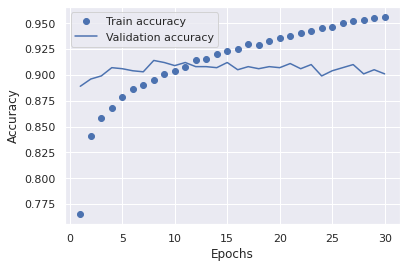

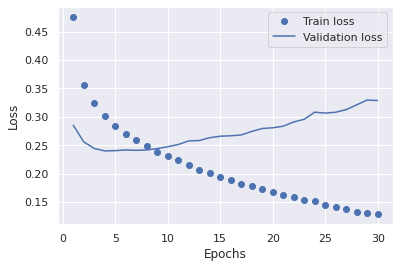

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()


epochs = range(1, len(history.history['loss']) + 1)
acc = history.history['acc']
val_acc = history.history['val_acc']

plt.plot(epochs, acc, 'bo', label='Train accuracy')
plt.plot(epochs, val_acc, '-', label='Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.figure()

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(epochs, loss, 'bo', label='Train loss')
plt.plot(epochs, val_loss, '-', label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [13]:
model.save('cats_and_dogs_small_3.h5')